In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timezone
import time 
start_time = time.time()

In [ ]:
df_fuel_trans = pd.read_csv('data/BGETCHDATA.PTCHTRANH.csv')
df_truck_info = pd.read_csv('data/IBGEFILE.UNITS.csv')
df_fuel_opt = pd.read_csv('data/BGEIDSC.EF2EFFP.csv')
df_level = pd.read_csv('data/Extranet2.ExactFuelTankLevels.csv')
df_events = pd.read_csv('data/Extranet2.ExactFuelEvents.csv')
df_events['EventTimeStamp'] = pd.to_datetime(df_events['EventTimeStamp'])
df_performance = pd.read_csv('data/Extranet2.QCPerformanceExtracts.csv')
df_events = df_events.drop(columns=['EquipmentType']) ## - 1 unique entry
df_event_level = pd.merge(df_events, df_level, how='left', left_on='ESS_Id', right_on='ExactFuelEventId')

In [ ]:
# NEED TO CONVERT  df_fuel_trans.TRNUNT  and EquipmentID to same dtype
df_fuel_trans['TRNUNT'] = df_fuel_trans['TRNUNT'].apply(str)
df_events['EquipmentID'] = df_events['EquipmentID'].apply(str)

df_fuel_trans['TRNUNT'] = df_fuel_trans['TRNUNT'].str.strip()
df_events['EquipmentID'] = df_events['EquipmentID'].str.strip()

print(df_fuel_trans['TRNUNT'].dtype)
print(df_events['EquipmentID'].dtype)

In [ ]:
fuels = ['ULSD', 'FUEL', 'CDSL', 'DEFC', 'DSL1', 'BDSL']

In [ ]:
###### REMOVING ODOMETER READING OF 0 #######
df_events_no_blank_odo = df_events[~(df_events[['Odometer']] == 0).any(axis=1)]

truck_events = df_events_no_blank_odo.EquipmentID.value_counts().sort_values(ascending=False)
truck_events = pd.DataFrame(data=truck_events)
truck_events = truck_events.reset_index();
truck_events.columns = ['EquipmentID','Count']

In [ ]:
miles_by_truck = pd.DataFrame()
miles_by_truck['min_odo'] = df_events_no_blank_odo.groupby(['EquipmentID'])['Odometer'].min()
miles_by_truck['max_odo'] = df_events_no_blank_odo.groupby(['EquipmentID'])['Odometer'].max()
miles_by_truck['mean_odo'] = df_events_no_blank_odo.groupby(['EquipmentID'])['Odometer'].mean()
miles_by_truck['median_odo'] = df_events_no_blank_odo.groupby(['EquipmentID'])['Odometer'].median()
miles_by_truck['min_mean_variance'] = miles_by_truck['max_odo']-miles_by_truck['mean_odo']
miles_by_truck['max_mean_variance'] = miles_by_truck['mean_odo']-miles_by_truck['min_odo']
miles_by_truck['variance_of_variances'] = miles_by_truck['max_mean_variance']-miles_by_truck['min_mean_variance']
miles_by_truck['odo_change'] = (miles_by_truck['max_odo'] - miles_by_truck['min_odo'])
miles_by_truck = miles_by_truck.reset_index()
miles_by_truck = miles_by_truck[miles_by_truck['odo_change'] > 5000] 
miles_by_truck['EquipmentID'] = miles_by_truck['EquipmentID'].apply(str)

In [ ]:
df_events = pd.merge(left=df_events, right=miles_by_truck, how='left', left_on='EquipmentID', right_on='EquipmentID')

In [ ]:
df_events['odo_from_median_pct'] = (df_events.Odometer/df_events.median_odo)

In [ ]:
(df_events[['EquipmentID','Odometer','median_odo','odo_from_median_pct']]).head()

In [ ]:
df_events_no_nan = df_events.dropna(thresh=5) 

In [ ]:
df_events_no_nan.head()

# NEED TO DROP NAN FROM MEDIAN_PCT

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


ValueError: max must be larger than min in range parameter.

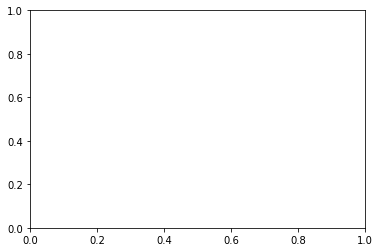

In [359]:
_ = plt.hist(df_events_no_nan.odo_from_median_pct)
plt.show()

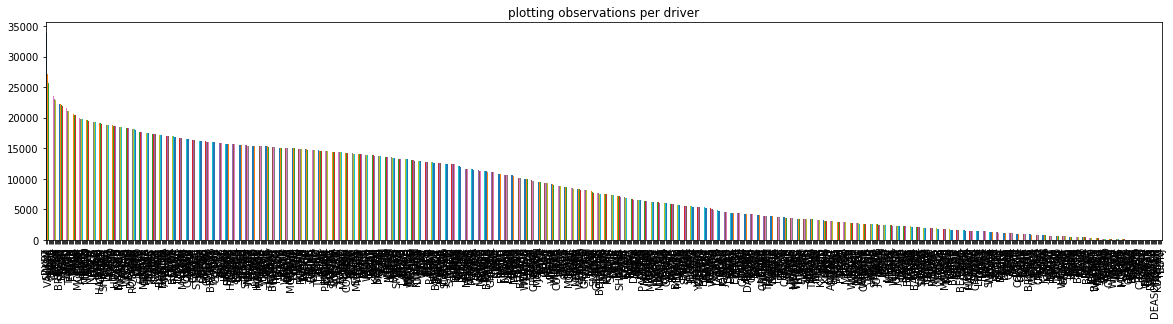

In [327]:
driver_events.plot(kind='bar', figsize=(20,4), title='plotting observations per driver');

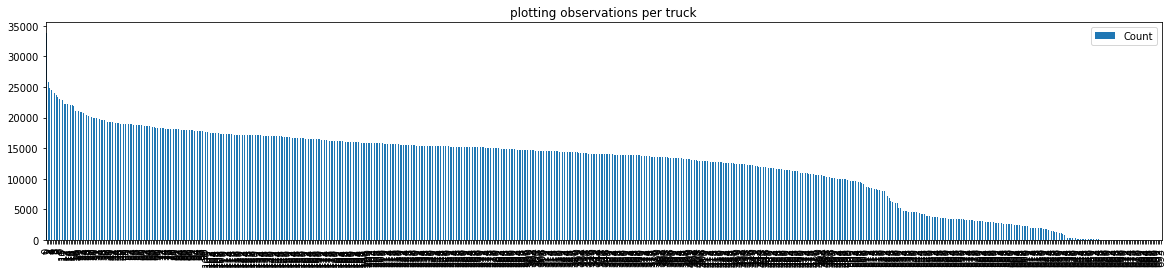

In [329]:
truck_events.plot(kind='bar', figsize=(20,4), title='plotting observations per truck');

# outlier in odometer identified #
# consider outlier identification, delta between MEAN and MEDIAN ?

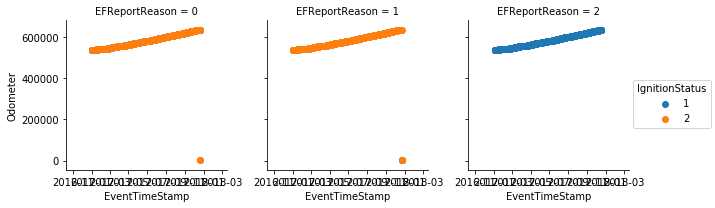

In [239]:
# outlier in odometer identified #
truck_1601 = df_event_level.loc[(df_event_level['EquipmentID'] == 1601)] 
fg = sns.FacetGrid(data=truck_1601, hue='IgnitionStatus', col='EFReportReason')
fg.map(plt.scatter, 'EventTimeStamp', 'Odometer').add_legend()

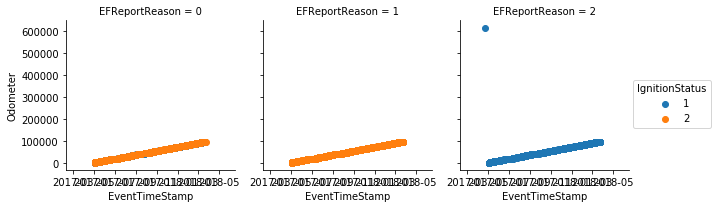

In [233]:
truck_2061 = df_event_level.loc[(df_event_level['EquipmentID'] == 2061)] 
fg = sns.FacetGrid(data=truck_2061, hue='IgnitionStatus', col='EFReportReason')
fg.map(plt.scatter, 'EventTimeStamp', 'Odometer').add_legend()

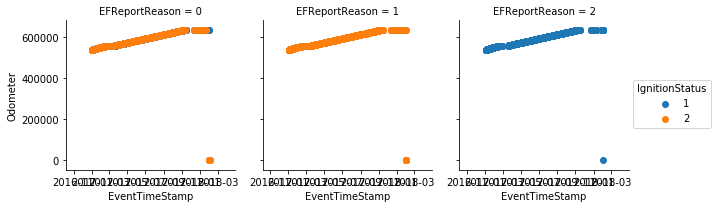

In [236]:
truck_1607 = df_event_level.loc[(df_event_level['EquipmentID'] == 1607)] 
fg = sns.FacetGrid(data=truck_1607, hue='IgnitionStatus', col='EFReportReason')
fg.map(plt.scatter, 'EventTimeStamp', 'Odometer').add_legend()

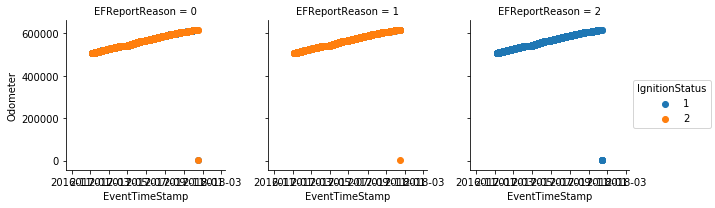

In [237]:
truck_1597 = df_event_level.loc[(df_event_level['EquipmentID'] == 1597)] 
fg = sns.FacetGrid(data=truck_1597, hue='IgnitionStatus', col='EFReportReason')
fg.map(plt.scatter, 'EventTimeStamp', 'Odometer').add_legend()

In [330]:
#truck_1713 = df_event_level.loc[(df_event_level['EquipmentID'] == 1713) & (df_event_level['IgnitionStatus'] == 1)] 
truck_1713 = df_event_level.loc[(df_event_level['EquipmentID'] == 1713)] 

In [163]:
# descending fuel readings only
truck_1713_dec = truck_1713
truck_1713_dec['fuel_delta'] = truck_1713_dec.TankLevelGallons - truck_1713_dec.TankLevelGallons.shift(1)
truck_1713_dec['odometer_delta'] = truck_1713_dec.Odometer - truck_1713_dec.Odometer.shift(1)
truck_1713_dec['mpg_change'] = truck_1713_dec.odometer_delta / truck_1713_dec.fuel_delta

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

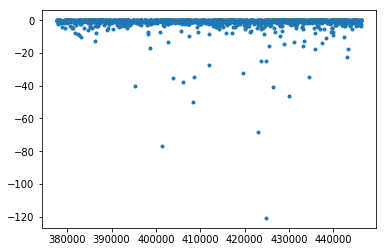

In [165]:
truck_1713_map = truck_1713_dec
truck_1713_map = truck_1713_map[truck_1713_map['mpg_change'] < 0]
plt.plot(truck_1713_map.Odometer, truck_1713_map.mpg_change, marker='.', linestyle='none')
plt.show()

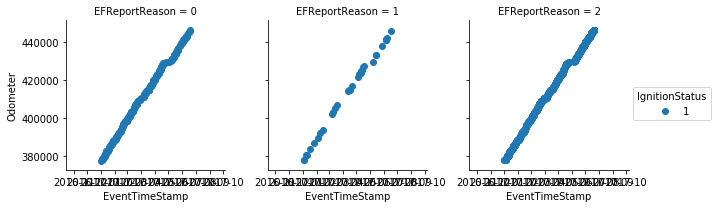

In [331]:
truck_1713_map_wSpeed = truck_1713_map[truck_1713_map['Speed'] > 0]
truck_1713_map_wSpeed = truck_1713_map_wSpeed.sort_values(by=['EventTimeStamp'])
truck_1713_map_wSpeed['month_ts'] = pd.DatetimeIndex(truck_1713_map_wSpeed['EventTimeStamp']).month
fg = sns.FacetGrid(data=truck_1713_map_wSpeed, hue='IgnitionStatus', col='EFReportReason')
fg.map(plt.scatter, 'EventTimeStamp', 'Odometer').add_legend()

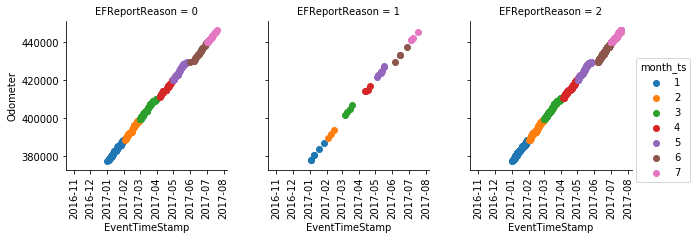

In [174]:
fg = sns.FacetGrid(data=truck_1713_map_wSpeed, hue='month_ts', col='EFReportReason')
fg.map(plt.scatter, 'EventTimeStamp', 'Odometer').add_legend()
fg.set_xticklabels(rotation = 90);

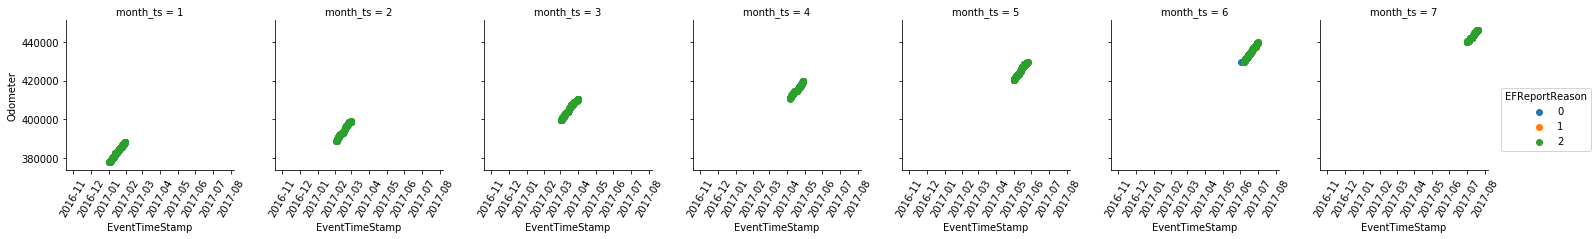

In [175]:
fg = sns.FacetGrid(data=truck_1713_map_wSpeed, hue='EFReportReason', col='month_ts')
fg.map(plt.scatter, 'EventTimeStamp', 'Odometer').add_legend()
fg.set_xticklabels(rotation = 60);

# Fuel by truck, miles by truck, fuel usage as a function of odometer change by truck

In [178]:
#df_fuel_trans
df_fuel_trans_fuels = df_fuel_trans[df_fuel_trans['TRNPI1'].isin(fuels)]
df_fuel_trans_fuels = df_fuel_trans_fuels.drop(columns=['TRNPI2','TRNPI3','TRNPI4','TRNPI5','TRNPI6','TRNPQ2','TRNPQ3','TRNPQ4','TRNPQ5','TRNPQ6'])

In [179]:
fuel_by_truck = df_fuel_trans_fuels.groupby(['TRNUNT','TRNPI1'], as_index=False)['TRNPQ1'].sum()

In [180]:
fuel_by_truck = fuel_by_truck[fuel_by_truck['TRNPQ1'] > 100]
fuel_by_truck['TRNUNT'] = fuel_by_truck['TRNUNT'].apply(str)

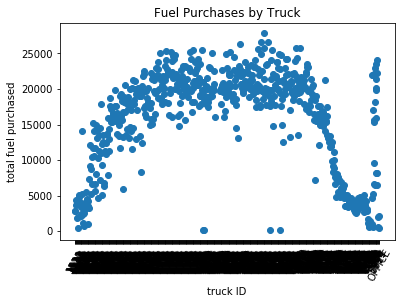

In [332]:
############### FUEL BY TRUCK SHOWN ###################
######### excluded trucks with < 100 gallons #########
#### NEED TO BRING IN ODOMETER CHANGE (Max - Min) ###
################## split by month? #################

_ = plt.scatter('TRNUNT','TRNPQ1',data=fuel_by_truck)
_ = plt.title('Fuel Purchases by Truck')
_ = plt.xlabel('truck ID')
_ = plt.ylabel('total fuel purchased')
_ = plt.xticks(rotation=60)
plt.show()

In [335]:
miles_by_truck

,EquipmentID,min_odo,max_odo,mean_odo,median_odo,min_mean_variance,max_mean_variance,variance_of_variances,odo_change
0,0,7437.8,557458.4,220890.817002,100314.50,336567.582998,213453.017002,-123114.565997,550020.6
1,105304126,104315.7,538729.6,200225.262338,104315.70,338504.337662,95909.562338,-242594.775325,434413.9
14,105387350,241063.5,479301.3,294827.660523,241063.50,184473.639477,53764.160523,-130709.478954,238237.8
36,105451937,20903.6,492504.8,440104.666667,492504.80,52400.133333,419201.066667,366800.933333,471601.2
37,108034511,51290.9,89520.6,76366.841509,77725.60,13153.758491,25075.941509,11922.183019,38229.7
39,1508,105806.5,575668.8,259019.186957,105828.95,316649.613043,153212.686957,-163436.926087,469862.3
43,1520,511876.7,587759.8,579195.280163,579919.65,8564.519837,67318.580163,58754.060326,75883.1
44,1521,457.7,612074.6,597987.776550,597780.80,14086.823450,597530.076550,583443.253100,611616.9
45,1522,206524.5,226182.2,216859.032633,216718.90,9323.167367,10334.532633,1011.365266,19657.7
46,1523,552332.1,563615.1,553378.183030,552350.90,10236.916970,1046.083030,-9190.833939,11283.0


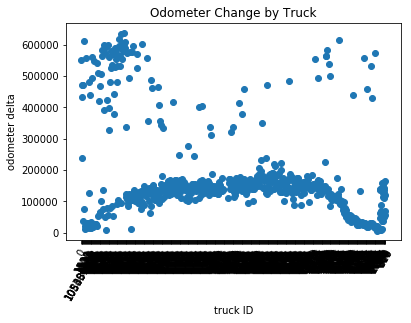

In [337]:
_ = plt.scatter('EquipmentID','odo_change',data=miles_by_truck)
_ = plt.title('Odometer Change by Truck')
_ = plt.xlabel('truck ID')
_ = plt.ylabel('odometer delta')
_ = plt.xticks(rotation=60)
plt.show()

In [322]:
fuel_odo_use = pd.DataFrame()
fuel_odo_use = pd.merge(fuel_by_truck, miles_by_truck, how='left', left_on='TRNUNT', right_on='EquipmentID')
fuel_odo_use = pd.merge(fuel_odo_use, truck_events, how='left', left_on='EquipmentID', right_on='EquipmentID')
fuel_odo_use

,TRNUNT,TRNPI1,TRNPQ1,EquipmentID,min_odo,max_odo,mean_odo,min_mean_variance,max_mean_variance,variance_of_variances,odo_change,Count
0,,ULSD,2887.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1520,ULSD,2767.74,1520,511876.7,587759.8,579195.280163,8564.519837,67318.580163,58754.060326,75883.1,1840.0
2,1521,ULSD,4406.22,1521,457.7,612074.6,597987.776550,14086.823450,597530.076550,583443.253100,611616.9,2597.0
3,1522,ULSD,3662.87,1522,206524.5,226182.2,216859.032633,9323.167367,10334.532633,1011.365266,19657.7,2666.0
4,1523,ULSD,1909.91,1523,552332.1,563615.1,553378.183030,10236.916970,1046.083030,-9190.833939,11283.0,165.0
5,1524,ULSD,3912.98,1524,492407.9,517765.3,504734.842187,13030.457813,12326.942187,-703.515626,25357.4,2387.0
6,1525,ULSD,427.13,1525,447.2,556613.3,554562.872970,2050.427030,554115.672970,552065.245939,556166.1,788.0
7,1526,ULSD,1942.99,1526,576860.3,590814.4,584408.358482,6406.041518,7548.058482,1142.016965,13954.1,1621.0
8,1527,ULSD,4736.10,1527,598520.9,629400.4,614199.505863,15200.894137,15678.605863,477.711726,30879.5,3309.0
9,1528,ULSD,5016.94,1528,587206.3,618110.9,602348.715844,15762.184156,15142.415844,-619.768312,30904.6,3465.0


In [316]:
#print(fuel_by_truck[fuel_by_truck['TRNUNT'] == '1520'])
#print(miles_by_truck[miles_by_truck['EquipmentID'] == '1520'])
print(truck_events['EquipmentID'])

#print(fuel_by_truck['TRNUNT'].head(20))
#print(miles_by_truck['EquipmentID'].head(20))


0      33901
1      25750
2      24871
3      24533
4      24104
5      24056
6      23643
7      23300
8      23082
9      22840
10     22801
11     22278
12     22239
13     22141
14     22072
15     22059
16     22053
17     21910
18     21135
19     21054
20     20997
21     20975
22     20824
23     20776
24     20542
25     20394
26     20280
27     20216
28     20030
29     19917
       ...  
664       10
665       10
666        9
667        9
668        7
669        6
670        6
671        6
672        5
673        5
674        4
675        4
676        4
677        4
678        4
679        3
680        3
681        3
682        3
683        3
684        2
685        2
686        2
687        1
688        1
689        1
690        1
691        1
692        1
693        1
Name: EquipmentID, Length: 694, dtype: object


In [240]:
fuel_odo_use = fuel_odo_use.dropna(thresh=5) #drop row if it has 5 nan values or more
fuel_odo_use.sort_values('odo_change')


,index,TRNUNT,TRNPI1,TRNPQ1,EquipmentID,min_odo,max_odo,mean_odo,min_mean_variance,max_mean_variance,variance_of_variances,odo_change
624,628,2144,ULSD,4193.69,2144,23015.0,29730.6,28727.921250,1002.678750,5712.921250,4710.242500,6715.6
628,636,2152,ULSD,1119.00,2152,948.7,8798.8,7889.709202,909.090798,6941.009202,6031.918405,7850.1
627,634,2150,ULSD,1387.65,2150,1262.5,9523.8,8635.741667,888.058333,7373.241667,6485.183333,8261.3
631,643,301,ULSD,5187.62,301,342355.5,352014.6,346900.953799,5113.646201,4545.453799,-568.192403,9659.1
47,49,1569,ULSD,4722.54,1569,517996.2,527936.1,523240.984714,4695.115286,5244.784714,549.669428,9939.9
100,102,1622,ULSD,5952.91,1622,516759.2,526931.8,521581.063578,5350.736422,4821.863578,-528.872845,10172.6
625,629,2145,ULSD,2806.02,2145,7680.4,18959.9,10615.860000,8344.040000,2935.460000,-5408.580000,11279.5
3,4,1523,ULSD,1909.91,1523,552332.1,563615.1,553378.183030,10236.916970,1046.083030,-9190.833939,11283.0
633,645,303,ULSD,9519.36,303,231775.7,243508.7,237461.433215,6047.266785,5685.733215,-361.533569,11733.0
12,13,1532,ULSD,2344.21,1532,567877.6,581694.8,575565.346076,6129.453924,7687.746076,1558.292152,13817.2


# consider adding hue and facet grid to truck type, model, year, etc

# add column to calculate MPG:  odo delta / fuel purch

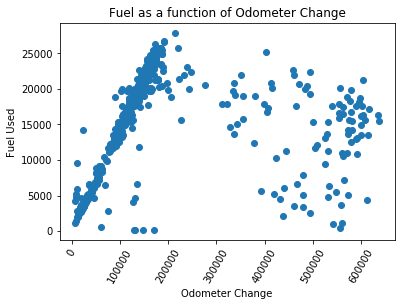

In [228]:
_ = plt.scatter('odo_change', 'TRNPQ1', data=fuel_odo_use)
_ = plt.xticks(rotation=60)
_ = plt.ylabel('Fuel Used')
_ = plt.xlabel('Odometer Change')
_ = plt.title('Fuel as a function of Odometer Change')
plt.show()

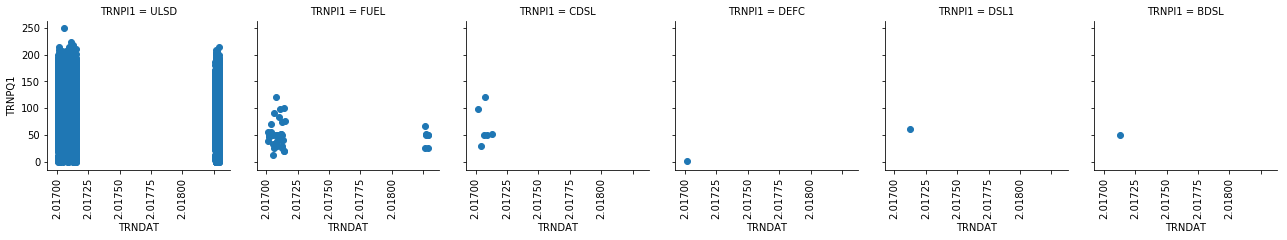

In [186]:
fg = sns.FacetGrid(data=df_fuel_trans_fuels, col='TRNPI1')
fg.map(plt.scatter,'TRNDAT','TRNPQ1')
fg.set_xticklabels(rotation = 90);

In [187]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 113.1089358329773 seconds ---


In [323]:
fuel_odo_use.to_csv('fuel_odo_use.csv')